In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

from JSAnimation import IPython_display
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

np.random.seed(1234)
torch.manual_seed(1234)

## check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [3]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs))

def toTensor(T):
    return torch.tensor(T).requires_grad_().to(device)

# Pinn model 

In [4]:
class PINN_Net(nn.Module):
    def __init__(self, layer_mat):
        super(PINN_Net, self).__init__()
        self.layer_num = len(layer_mat) - 1
        self.base = nn.Sequential()
        for i in range(0, self.layer_num - 1):
            self.base.add_module(str(i) + "linear", nn.Linear(layer_mat[i], layer_mat[i + 1]))
            # nn.init.kaiming_normal()
            self.base.add_module(str(i) + "Act", nn.Tanh())
        self.base.add_module(str(self.layer_num - 1) + "linear",
                             nn.Linear(layer_mat[self.layer_num - 1], layer_mat[self.layer_num]))
        self.lam1 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.lam2 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.Initial_param()

    def forward(self, x, y, t):
        X = torch.cat([x, y, t], 1).requires_grad_(True)
        predict = self.base(X)
        return predict

    def Initial_param(self):
        for name, param in self.base.named_parameters():
            if name.endswith('weight'):
                nn.init.xavier_normal_(param)
            elif name.endswith('bias'):
                nn.init.zeros_(param)

    def data_mse(self, x, y, t, u, v, p=None):
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        p_predict = predict_out[:, 1].reshape(-1, 1)
        u_predict = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
        v_predict = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
        mse = torch.nn.MSELoss()
        mse_predict = mse(u_predict, u) + mse(v_predict, v) 
        if p:
            mse_predict = mse_predict + mse(p_predict, p)
        return mse_predict

    def f_equation_inverse(self, x, y, t):
        lam1 = self.lam1
        lam2 = self.lam2
        predict_out = self.forward(x, y, t)
        psi = predict_out[:, 0].reshape(-1, 1)
        p = predict_out[:, 1].reshape(-1, 1)
        u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
        v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
        v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
        v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
        v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
        p_x = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
        p_y = torch.autograd.grad(p.sum(), y, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True)[0]
        f_u = u_t + lam1 *(u * u_x + v * u_y) + p_x - lam2 * (u_xx + u_yy)
        f_v = v_t + lam1 *(u * v_x + v * v_y) + p_y - lam2 * (v_xx + v_yy)
        l = torch.mean(f_u**2) + torch.mean(f_v**2)
        return l

# data

In [5]:
# Load Data
data = scipy.io.loadmat('cylinder_nektar_wake.mat')

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

print(N,T)

5000 200


# training data for baseline

In [6]:
# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Training Data
N_train = 5000
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

In [7]:
x_clone = torch.tensor(x_train).requires_grad_().to(device)
y_clone = torch.tensor(y_train).requires_grad_().to(device)
t_clone = torch.tensor(t_train).requires_grad_().to(device)
u_clone = torch.tensor(u_train).requires_grad_().to(device)
v_clone = torch.tensor(v_train).requires_grad_().to(device)

In [8]:
def trainData(n,N=N,T=T):
    idx = np.random.choice(N*T, n, replace=False)
    #print(idx.shape)
    xt = x[idx,:]
    yt = y[idx,:]
    tt = t[idx,:]
    ut = u[idx,:]
    vt = v[idx,:]
    return toTensor(xt), toTensor(yt), toTensor(tt), toTensor(ut), toTensor(vt)

# trainning function

In [9]:
def learn(net, epochs = 5_000, lr =0.001, 
          x=x_clone,y=y_clone,t=t_clone,u=u_clone,v=v_clone):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    l = []
    start = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()
        mse_predict = net.data_mse(x, y, t, u, v)
        mse_equation = net.f_equation_inverse(x, y, t)
        loss = mse_predict + mse_equation
        loss.backward()
        l.append(loss.data.cpu().numpy())
        optimizer.step()
    return time.time()-start, l

# test Function

In [10]:
def test(net, snap):
    snap = np.array([snap])
    x_star = X_star[:,0:1]
    y_star = X_star[:,1:2]
    t_star = TT[:,snap]

    u_test = U_star[:,0,snap]
    v_test = U_star[:,1,snap]

    x_test = torch.tensor(x_star).requires_grad_().to(device)
    y_test = torch.tensor(y_star).requires_grad_().to(device)
    t_test = torch.tensor(t_star).requires_grad_().to(device)
    
    out = net.forward(x_test, y_test, t_test)
    #print(out)
    psi_pred = out[:, 0].reshape(-1, 1)
    u_pred = torch.autograd.grad(psi_pred.sum(), y_test, create_graph=True)[0]
    v_pred = -torch.autograd.grad(psi_pred.sum(), x_test, create_graph=True)[0]

    u_pred = u_pred.data.cpu().numpy()
    v_pred = v_pred.data.cpu().numpy()
    
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u,2)
    error_v = np.linalg.norm(v_test-v_pred,2)/np.linalg.norm(v,2)
    return error_u, error_v

# real Flow field

In [11]:
Xx = X_star[:,0].reshape(-1,100)
Xy = X_star[:,1].reshape(-1,100)
Uu = U_star[:,0,:].reshape((50,100,T))
Uv = U_star[:,1,:].reshape((50,100,T))

In [12]:
print(Xx.shape, Xy.shape, Uu.shape, Uv.shape)

(50, 100) (50, 100) (50, 100, 200) (50, 100, 200)


In [13]:
slow = 1
fps = int(T//t_star.max()) /slow ### frames of the simulation
interval = int(1/fps * 1000) ### miliseconds

print(fps, interval)

10.0 100


In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
def animate(tt):
    ax.clear()       
    ax.grid()
    
    title = (tt * interval)/(1000*slow)
    if slow != 1:
        ax.set_title(str(title)+' seconds slowed x'+str(1/slow))
    else:
        ax.set_title(str(title)+' seconds')
    ax.streamplot(Xx,Xy,Uu[:,:,tt],Uv[:,:,tt],color= np.hypot(Uu[:,:,tt], Uv[:,:,tt]), cmap='viridis', density=1.5)
    ax.set_xlim((Xx.min(),Xx.max()))
    ax.set_ylim((Xy.min(),Xy.max()))
    
plt.close()

anim = FuncAnimation(fig, animate, frames=T, interval=interval)
anim.save("flow2.gif", dpi=300, writer=PillowWriter(fps=fps))
#HTML(anim.to_jshtml())

# sensors

In [15]:
### static sensors positions
n_sensor = 5 #number of sensors
r = 0.75 #radius measure
sensors = np.array([[2,-1],[3,1],[4.5,0],[6,-1],[7,1]])

### indices in the data-array
i=[]
j=[]
for s in sensors:
    ix = np.argmin(abs(Xx[0,:]-s[0]))
    jy = np.argmin(abs(Xy[:,0].T-s[1]))
    i.append(ix)
    j.append(jy)
print(i,j)
print(Xx[0,i],Xy[j,0].T)

[14, 28, 50, 71, 85] [12, 37, 24, 12, 37]
[1.98989899 2.97979798 4.53535354 6.02020202 7.01010101] [-1.02040816  1.02040816 -0.04081633 -1.02040816  1.02040816]


In [16]:
### distance measure
### radius 0.75 discretizes into ij range
delta_x = Xx[0,1]-Xx[0,0] 
delta_y = Xy[1,0]-Xy[0,0]
print(delta_x,delta_y)
rangei = int(r/delta_x)
rangej = int(r/delta_y)
print(rangei, rangej)
### the sensors will sample in a area
### of rangei X rangej around their center
### 5 samples at a time

0.07070707070707072 0.08163265306122458
10 9


In [17]:
### samples of each sensor
### 5 samples per sensor
samplesi = np.random.randint(low=-rangei,high=rangei,size=(n_sensor,5,60)) ### i samples
samplesj = np.random.randint(low=-rangej,high=rangej,size=(n_sensor,5,60)) ### j samples
print(samplesj.shape)

(5, 5, 60)


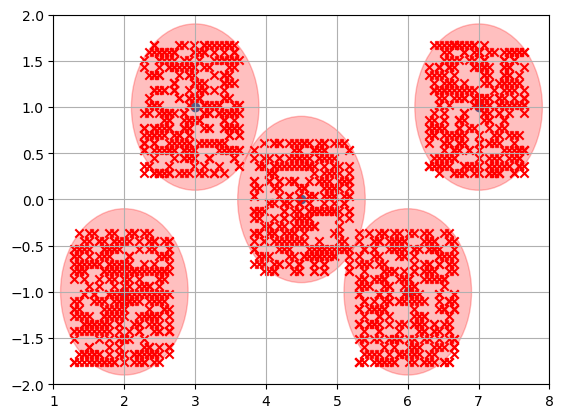

In [19]:
plt.scatter(sensors[:,0],sensors[:,1])

for s in sensors:
    circle1 = plt.Circle((s[0], s[1]), r+0.15, color='r',alpha=.25)
    plt.gca().add_patch(circle1)

senSamplei = []
senSamplej = []

for sen in range(n_sensor):
    si = i[sen] + samplesi[sen,:]
    sj = j[sen] + samplesj[sen,:]
    senSamplei.append(si)
    senSamplej.append(sj)
    
senSamplei = np.array(senSamplei).reshape(-1,1)
senSamplej = np.array(senSamplej).reshape(-1,1)

plt.scatter(Xx[0,senSamplei],Xy[senSamplej,0], marker='x',color='r')

plt.xlim([int(Xx.min()),int(Xx.max())])
plt.ylim([int(Xy.min()),int(Xy.max())])
plt.grid()
plt.show()

# data from sensors

In [20]:
### 300 samples per sensor
### 5 samples per time steps
### 300/5 = 60 time steps
### 6 seconds in simulation
ts = np.arange(50,50+60)
Xsample = np.tile(Xx[0,senSamplei],(len(ts),1))
Ysample = np.tile(Xx[0,senSamplej],(len(ts),1))
Tsample = np.tile(t_star[ts],(1,len(Xx[0,senSamplei]))).flatten()[:,None]
Usample = Uu[senSamplej,senSamplei,ts].flatten('F')[:,None]
Vsample = Uv[senSamplej,senSamplei,ts].flatten('F')[:,None]
    
print(Xx[0,senSamplei].shape,Xy[senSamplej,0].shape,t_star[ts].shape,
      Uu[senSamplej,senSamplei,ts].shape,Uv[senSamplej,senSamplei,ts].shape)

print(Xsample.shape, Ysample.shape, Tsample.shape, Usample.shape, Vsample.shape)

(1500, 1) (1500, 1) (60, 1) (1500, 60) (1500, 60)
(90000, 1) (90000, 1) (90000, 1) (90000, 1) (90000, 1)


In [21]:
def extract_data(k):
    if k ==5:
        return Xsample,Ysample,Tsample,Usample,Vsample
    index = []
    for i in range(60):
        index.append(np.arange(0+(25*i),5*k+(25*i)))
    index = np.array(index).flatten()
    return Xsample[index],Ysample[index],Tsample[index],Usample[index],Vsample[index]

print(extract_data(7)[0].shape)

(2100, 1)


# parameters and simulation

In [22]:
### we will test three layer configuration
### from one to five sensors
### 3000 epochs

l1 = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
l2 = [3, 20, 20, 20, 20, 20, 2]
l3 = [3, 20, 20, 20, 2]

layers = [l1, l2, l3]
samples = [5000,2000,500]

### different combinations 
### report of error of velocity of the flow
### train error and wall clock time for training
bs_t = []
bs_loss = []
bs_err = []
baseL = []

models = []
losses = []
times = []
errors = []
names = []
name_mdl = []

# Training of the model

In [23]:
for l in layers:
    idx = len(l)-2
    for smp in samples:
        baseL.append(PINN_Net(l).double().to(device))
        x1,y1,t1,u1,v1 = trainData(smp)
        base_time, loss = learn(baseL[-1],x=x1,y=y1,t=t1,u=u1,v=v1)
        ue, ve = test(baseL[-1], 70)
        bs_t.append(base_time)
        bs_loss.append(loss)
        bs_err.append([ue,ve])
        names.append('baseline_layers'+str(idx)+' s'+str(smp))
        print(names[-1])
    #for k in range(3,n+1,2):
    k = 7
    models.append(PINN_Net(l).double().to(device))
    x1,y1,t1,u1,v1 = extract_data(k)
    x_ = torch.tensor(x1).requires_grad_().to(device)
    y_ = torch.tensor(y1).requires_grad_().to(device)
    t_ = torch.tensor(t1).requires_grad_().to(device)
    u_ = torch.tensor(u1).requires_grad_().to(device)
    v_ = torch.tensor(v1).requires_grad_().to(device)
    bs, ls = learn(models[-1], x=x_,y=y_,t=t_,u=u_,v=v_)
    ue_, ve_ = test(models[-1],70)
    losses.append(ls)
    times.append(bs)
    errors.append([ue_,ve_])
    name_mdl.append('layers'+str(idx)+' sensors'+str(k))
    print(name_mdl[-1])

baseline_layers8 s5000
baseline_layers8 s2000
baseline_layers8 s500
layers8 sensors7
baseline_layers5 s5000
baseline_layers5 s2000
baseline_layers5 s500
layers5 sensors7
baseline_layers3 s5000
baseline_layers3 s2000
baseline_layers3 s500
layers3 sensors7


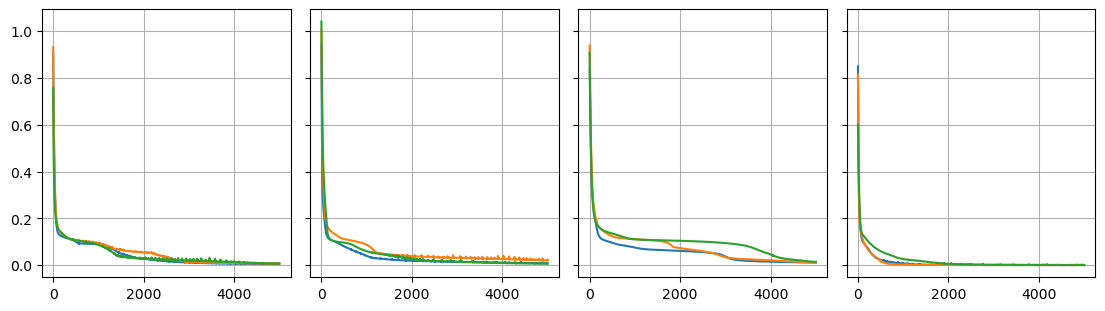

In [24]:
f,a = plt.subplots(1,4, figsize=(11,3), sharey=True, constrained_layout=True)
a[0].plot(bs_loss[0])
a[0].plot(bs_loss[1])
a[0].plot(bs_loss[2])
a[0].grid()
a[1].plot(bs_loss[3])
a[1].plot(bs_loss[4])
a[1].plot(bs_loss[5])
a[1].grid()
a[2].plot(bs_loss[6])
a[2].plot(bs_loss[7])
a[2].plot(bs_loss[8])
a[2].grid()
a[3].plot(losses[0])
a[3].plot(losses[1])
a[3].plot(losses[2])
a[3].grid()

plt.show()

In [27]:
names, name_mdl

(['baseline_layers8 s5000',
  'baseline_layers8 s2000',
  'baseline_layers8 s500',
  'baseline_layers5 s5000',
  'baseline_layers5 s2000',
  'baseline_layers5 s500',
  'baseline_layers3 s5000',
  'baseline_layers3 s2000',
  'baseline_layers3 s500'],
 ['layers8 sensors7', 'layers5 sensors7', 'layers3 sensors7'])

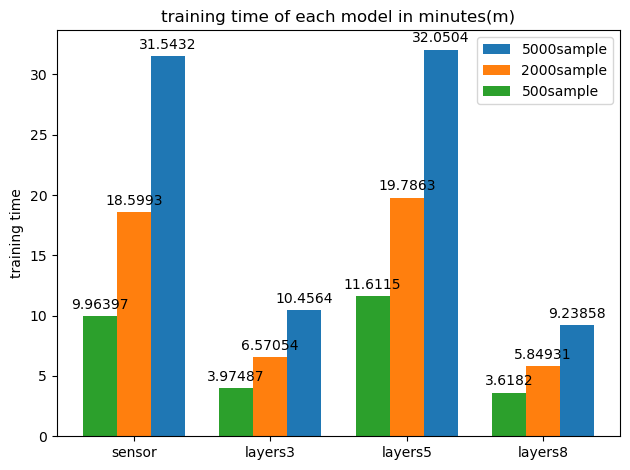

In [35]:
labels = ['sensor', 'layers3', 'layers5', 'layers8']
times_L8 = np.array([times[0], bs_t[2], bs_t[1], bs_t[0]])/60
times_L5 = np.array([times[1], bs_t[5], bs_t[4], bs_t[3]])/60
times_L3 = np.array([times[2], bs_t[8], bs_t[7], bs_t[6]])/60

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width, times_L8, width, label='5000sample')
rects2 = ax.bar(x , times_L5, width, label='2000sample')
rects3 = ax.bar(x - width, times_L3, width, label='500sample')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('training time')
ax.set_title('training time of each model in minutes(m)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

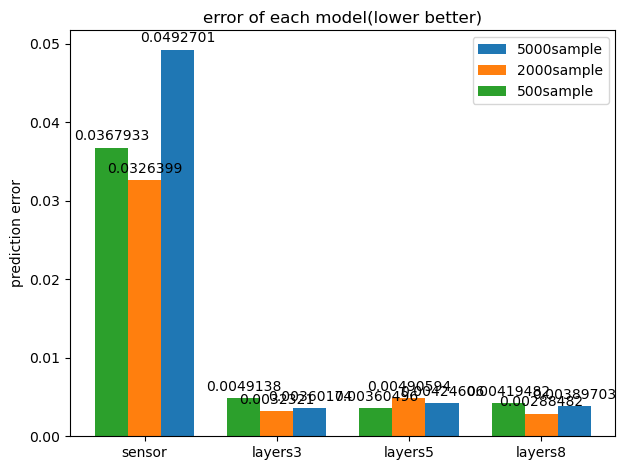

In [36]:
labels = ['sensor', 'layers3', 'layers5', 'layers8']
times_L8 = [errors[0][0], bs_err[2][0], bs_err[1][0], bs_err[0][0]]
times_L5 = [errors[1][0], bs_err[5][0], bs_err[4][0], bs_err[3][0]]
times_L3 = [errors[2][0], bs_err[8][0], bs_err[7][0], bs_err[6][0]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width, times_L8, width, label='5000sample')
rects2 = ax.bar(x , times_L5, width, label='2000sample')
rects3 = ax.bar(x - width, times_L3, width, label='500sample')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('prediction error')
ax.set_title('error of each model(lower better)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

# predicted flow

In [ ]:
# %%script echo skipping
from IPython.display import clear_output

U_pred = np.zeros_like(Uu)
V_pred = np.zeros_like(Uv)
for t_ in range(T):
    x_s = torch.tensor(X_star[:,0:1]).requires_grad_().to(device)
    y_s = torch.tensor(X_star[:,1:2]).requires_grad_().to(device)
    t_s = torch.tensor(TT[:,t_][:,None]).requires_grad_().to(device)
    
    pred = baseline.forward(x_s, y_s, t_s)
    psi = pred[:, 0].reshape(-1, 1)
    u_predict = torch.autograd.grad(psi.sum(), y_s, create_graph=True)[0]
    v_predict = -torch.autograd.grad(psi.sum(), x_s, create_graph=True)[0]
    
    u_pred = u_predict.data.cpu().numpy()
    v_pred = v_predict.data.cpu().numpy()
    
    U_pred[:,:,t_] = u_pred.reshape(Uu[:,:,0].shape)
    V_pred[:,:,t_] = v_pred.reshape(Uu[:,:,0].shape)


fig, ax = plt.subplots(figsize=(7,5))
def animate_pred(tt):
    clear_output(wait=True)
    print(tt/T * 100, '%')
    ax.clear()       
    ax.grid()
    
    title = (tt * interval)/(1000*slow)
    if slow != 1:
        ax.set_title(str(title)+' seconds slowed x'+str(1/slow))
    else:
        ax.set_title(str(title)+' seconds')
    ax.streamplot(Xx,Xy,U_pred[:,:,tt],V_pred[:,:,tt],color= np.hypot(U_pred[:,:,tt], V_pred[:,:,tt]), cmap='viridis', density=1.5)
    ax.set_xlim((Xx.min(),Xx.max()))
    ax.set_ylim((Xy.min(),Xy.max()))
    
plt.close()

anim = FuncAnimation(fig, animate_pred, frames=T, interval=interval)
anim.save("predbestflow.gif", dpi=300, writer=PillowWriter(fps=fps))
#HTML(anim.to_jshtml())

# NAVIGATION with POLICY

we can use a discretization of the current flow map and apply POLICY iterative method to find the best path for a desire location